# Определение перспективного тарифа для телеком-компании

## Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Для анализа имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

Тариф «Смарт»:

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
1. минута разговора: 3 рубля
2. сообщение: 3 рубля
3. 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»:

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

1. минута разговора: 1 рубль
2. сообщение: 1 рубль
3. 1 Гб интернет-трафика: 150 рублей

### Описание данных

Таблица users (информация о пользователях):

1. user_id — уникальный идентификатор пользователя
2. first_name — имя пользователя
3. last_name — фамилия пользователя
4. age — возраст пользователя (годы)
5. reg_date — дата подключения тарифа (день, месяц, год)
6. churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
7. city — город проживания пользователя
8. tariff — название тарифного плана

Таблица calls (информация о звонках):

1. id — уникальный номер звонка
2. call_date — дата звонка
3. duration — длительность звонка в минутах
4. user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

1. id — уникальный номер сообщения
2. message_date — дата сообщения
3. user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

1. id — уникальный номер сессии
2. mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
3. session_date — дата интернет-сессии
4. user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

1. tariff_name — название тарифа
2. rub_monthly_fee — ежемесячная абонентская плата в рублях
3. minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
4. messages_included — количество сообщений в месяц, включённых в абонентскую плату
5. mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
6. rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
7. rub_per_message — стоимость отправки сообщения сверх тарифного пакета
8. rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Ход исследования

1. Обзор данных.
2. Предобработка данных.
3. Расчет и добавление необходимых показателей.
4. Исследование данных.
5. Проверка гипотез.
6. Ответы на вопросы и основной вывод.

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
import math
import seaborn as sns

### Прочтение файлов и просмотр первых строк полученных таблиц

Прочтем каждый файл с помощью библиотеки pandas и посмотрим имеющиеся в них сведения.

In [2]:
calls = pd.read_csv('~/Desktop/project_files/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
inet = pd.read_csv('~/Desktop/project_files/internet.csv', index_col=0)
inet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [4]:
messages = pd.read_csv('~/Desktop/project_files/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [5]:
tarif = pd.read_csv('~/Desktop/project_files/tariffs.csv')
tarif.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
user = pd.read_csv('~/Desktop/project_files/users.csv')
user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Ниже посмотрела, что нет ошибок и лишних названий в тарифов и обратила внимание, что пользователей с тарифом smart гораздо больше в данной выборке. 

In [7]:
user['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

### Изучение общей информации по каждой таблице данных

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
inet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
tarif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Исходя из общей информации, необходимо изменить типы данных в столбцах, хранящих данные о времени. Также проверить наличие пропусков и дубликатов, возможно переименовать названия столбцов. При этом, для исследования нам будет необходимо добавить дополнительные сведения.

### Гистограмма распределения интернет-трафика

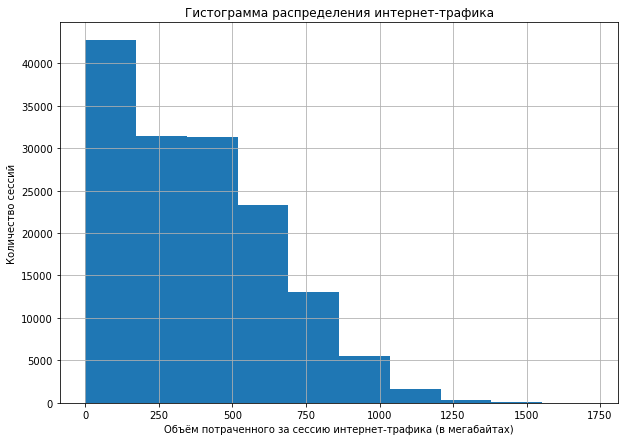

In [13]:
plt.figure(figsize=(10, 7))
inet['mb_used'].hist()
plt.title('Гистограмма распределения интернет-трафика')
plt.xlabel('Объём потраченного за сессию интернет-трафика (в мегабайтах)')
plt.ylabel('Количество сессий')
plt.show()

In [14]:
print('Максимальный объём потраченного за сессию интернет-трафика в мегабайтах составляет: ', inet['mb_used'].max())

Максимальный объём потраченного за сессию интернет-трафика в мегабайтах составляет:  1724.83


Данная гистограмма показывает распределение интернет-трафика. На мой взгляд здесь аномалий нет. Есть немного выбивающихся значений, но я бы не считала это аномалией, так как 15-16 Гб может составлять объем какого-либо длительного видео, поэтому эти данные оставим.

Добавим в нашу гистограмму параметр bins для наглядности:

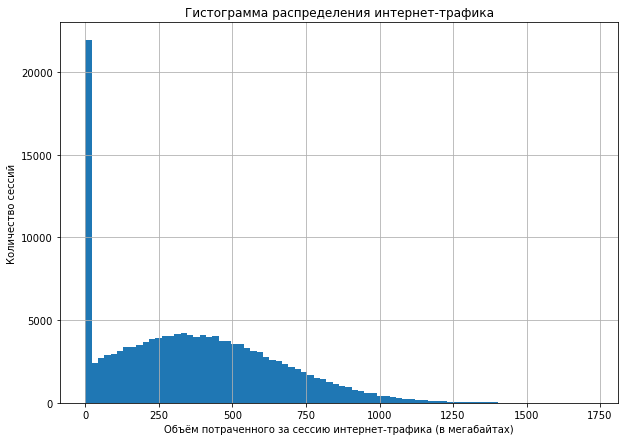

In [15]:
plt.figure(figsize=(10, 7))
inet['mb_used'].hist(bins = 80)
plt.title('Гистограмма распределения интернет-трафика')
plt.xlabel('Объём потраченного за сессию интернет-трафика (в мегабайтах)')
plt.ylabel('Количество сессий')
plt.show()

Имеется большое количество так называемых нулевых сессий. Возможно, клиенты пытались зайти в интернет, но не смогли, происходит какой-то обрыв сессий и звонков. В таких случаях информацию необходимо предоставлять техподдержке.

### Проверка на наличие дубликатов

Проверим таблицы на наличие явных дубликатов:

In [16]:
print('Количество дубликатов:', user.duplicated().sum())

Количество дубликатов: 0


In [17]:
print('Количество дубликатов:', messages.duplicated().sum())

Количество дубликатов: 0


In [18]:
print('Количество дубликатов:', inet.duplicated().sum())

Количество дубликатов: 0


In [19]:
print('Количество дубликатов:', calls.duplicated().sum())

Количество дубликатов: 0


После проведенной проверки дубликатов не выявлено.

## Предобработка данных

После просмотра общей информации по таблицам видно, что сведения с датами сохранены в формате object, поэтому сразу поменяем формат. 

In [20]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
inet['session_date'] = pd.to_datetime(inet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
user['churn_date'] = pd.to_datetime(user['churn_date'], format='%Y-%m-%d')
user['reg_date'] = pd.to_datetime(user['reg_date'], format='%Y-%m-%d')

Так как «Мегалайн» округляет секунды до минут, то для дальнейшего анализа нам необходимо в таблице с информацией о звонках также округлить до полных минут.

In [21]:
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Для дальнейшего исследования создадим столбец, в котором будут хранится даты звонков, округленные до месяца:

In [22]:
calls['month'] = calls['call_date'].to_numpy().astype('datetime64[M]')

In [23]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,2018-07-01
1,1000_1,2018-08-17,0.0,1000,2018-08-01
2,1000_2,2018-06-11,3.0,1000,2018-06-01
3,1000_3,2018-09-21,14.0,1000,2018-09-01
4,1000_4,2018-12-15,6.0,1000,2018-12-01


Также создаем столбец и округляем до месяца в следующей таблице:

In [24]:
inet['month'] = inet['session_date'].to_numpy().astype('datetime64[M]')

In [25]:
inet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


С таблицей сообщений проделываем такую же работу:

In [26]:
messages['month'] = messages['message_date'].to_numpy().astype('datetime64[M]')

In [27]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


### Расчет израсходованных минут, смс и интернета для каждого пользователя по месяцам

Создадим новую таблицу, где сгруппируем данные по пользователям и месяцам и таким образом получим данные, а именно сколько каждый пользователь расходует минут в месяц.

In [28]:
user_calls = (calls.groupby(['user_id', 'month'])['duration']
              .sum()
              .reset_index()
             )
user_calls.head()

,user_id,month,duration
0,1000,2018-05-01,159.0
1,1000,2018-06-01,172.0
2,1000,2018-07-01,340.0
3,1000,2018-08-01,408.0
4,1000,2018-09-01,466.0


Теперь проделаем то же самое по таблице с данными интернета.

In [29]:
user_inet = (inet.groupby(['user_id', 'month'])['mb_used']
             .sum()
             .reset_index()
            )
user_inet.head()

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91


Так как компания рассчет ведет в гигабайтах, то создадим столбец с нужными данными и округлим их:

In [30]:
user_inet['gb_used'] = user_inet['mb_used'] / 1024
user_inet['gb_used'] = np.ceil(user_inet['gb_used'])
user_inet.head()

,user_id,month,mb_used,gb_used
0,1000,2018-05-01,2253.49,3.0
1,1000,2018-06-01,23233.77,23.0
2,1000,2018-07-01,14003.64,14.0
3,1000,2018-08-01,14055.93,14.0
4,1000,2018-09-01,14568.91,15.0


Таблицу с данными по сообщениям также сгруппируем и получим нужные данные.

In [31]:
user_messages = (messages.groupby(['user_id', 'month'])['id']
                 .count()
                 .reset_index()
                )
user_messages.head()

,user_id,month,id
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


### Объединение данных в одну аналитическую таблицу

Для начала объединим таблицы с данными о звонках и смс.

In [32]:
user_calls_sms = user_calls.merge(user_messages, how='outer', on=['user_id', 'month'])

Теперь соединим полученную таблицу с данными по интернет-трафику и посмотрим, что получилось.

In [33]:
user_pivot = user_calls_sms.merge(user_inet, how='outer', on=['user_id', 'month'])
user_pivot

,user_id,month,duration,id,mb_used,gb_used
0,1000,2018-05-01,159.0,22.0,2253.49,3.0
1,1000,2018-06-01,172.0,60.0,23233.77,23.0
2,1000,2018-07-01,340.0,75.0,14003.64,14.0
3,1000,2018-08-01,408.0,81.0,14055.93,14.0
4,1000,2018-09-01,466.0,57.0,14568.91,15.0
...,...,...,...,...,...,...
3209,1489,2018-09-01,NaN,32.0,17206.30,17.0
3210,1489,2018-10-01,NaN,21.0,19559.44,20.0
3211,1489,2018-11-01,NaN,20.0,17491.56,18.0
3212,1489,2018-12-01,NaN,35.0,17322.51,17.0


In [34]:
user_pivot['month'].isna().sum()

0

Выше у нас получилась таблица, где отражены основные показатели для каждого пользователя по месяцам. Теперь ниже мы проверим на примере столбца с данными о звонках, чтобы удостовериться о целостности данных.

In [35]:
user_calls['duration'].sum()

1450301.0

In [36]:
user_pivot['duration'].sum()

1450301.0

Данные совпадают.

Теперь мы объеденим данные о пользователях и нашу таблицу, сохранив в новой таблице, и посмотрим что получилось.

In [37]:
at = user_pivot.merge(user, how='outer', on='user_id')
at.head()

,user_id,month,duration,id,mb_used,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,159.0,22.0,2253.49,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,172.0,60.0,23233.77,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,340.0,75.0,14003.64,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,408.0,81.0,14055.93,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,466.0,57.0,14568.91,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим в каких данных у нас образовались пропуски:

In [38]:
at.isna().sum()

user_id          0
month            2
duration        42
id             499
mb_used         13
gb_used         13
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

В данном случае исследовательскому анализу сильно помешают пропуски в столбце month (остальные сможем заменить 0), выведем эти строки с ними:

In [39]:
at[at['month'].isnull()]

,user_id,month,duration,id,mb_used,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
3214,1128,NaT,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
3215,1371,NaT,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Так как эти строки не несут какой-либо информации, мы их удалим:

In [45]:
at = at.query('user_id != 1128').reset_index(drop=True)
at = at.query('user_id != 1371').reset_index(drop=True)

Для дальнейшего исследования нам многие данные из таблицы пользователей не нужны, поэтому мы их просто уберем из таблицы.

In [46]:
at_1 = at[['user_id', 'reg_date', 'churn_date', 'city', 'month', 'duration', 'id', 'gb_used', 'tariff']].reset_index(drop=True)
at_1.head()

,user_id,reg_date,churn_date,city,month,duration,id,gb_used,tariff
0,1000,2018-05-25,NaT,Краснодар,2018-05-01,159.0,22.0,3.0,ultra
1,1000,2018-05-25,NaT,Краснодар,2018-06-01,172.0,60.0,23.0,ultra
2,1000,2018-05-25,NaT,Краснодар,2018-07-01,340.0,75.0,14.0,ultra
3,1000,2018-05-25,NaT,Краснодар,2018-08-01,408.0,81.0,14.0,ultra
4,1000,2018-05-25,NaT,Краснодар,2018-09-01,466.0,57.0,15.0,ultra


In [47]:
at_1.columns

Index(['user_id', 'reg_date', 'churn_date', 'city', 'month', 'duration', 'id',
       'gb_used', 'tariff'],
      dtype='object')

Для удобства переименуем столбцы.

In [48]:
at_1.columns = ['user_id', 'reg_date', 'churn_date', 'city', 'month', 'duration', 'sms', 'gb_used', 'tariff_name']
at_1.head()

,user_id,reg_date,churn_date,city,month,duration,sms,gb_used,tariff_name
0,1000,2018-05-25,NaT,Краснодар,2018-05-01,159.0,22.0,3.0,ultra
1,1000,2018-05-25,NaT,Краснодар,2018-06-01,172.0,60.0,23.0,ultra
2,1000,2018-05-25,NaT,Краснодар,2018-07-01,340.0,75.0,14.0,ultra
3,1000,2018-05-25,NaT,Краснодар,2018-08-01,408.0,81.0,14.0,ultra
4,1000,2018-05-25,NaT,Краснодар,2018-09-01,466.0,57.0,15.0,ultra


Теперь для дальнейшего удобства я заполню все имеющиеся пропуски нулями и буду это иметь ввиду при работе со столбцом о прекращении договора.

In [49]:
at_1.isna().sum()

user_id           0
reg_date          0
churn_date     3027
city              0
month             0
duration         40
sms             497
gb_used          11
tariff_name       0
dtype: int64

In [50]:
at_1['duration'] = at_1['duration'].fillna(0)
at_1['sms'] = at_1['sms'].fillna(0)
at_1['gb_used'] = at_1['gb_used'].fillna(0)
at_1['churn_date'] = at_1['churn_date'].fillna(0)


In [51]:
at_1.isna().sum()

user_id        0
reg_date       0
churn_date     0
city           0
month          0
duration       0
sms            0
gb_used        0
tariff_name    0
dtype: int64

И в финале мы объедением полученную таблицу с таблицей по тарифам

In [52]:
final_at = at_1.merge(tarif, how='left', on='tariff_name')
final_at.head()

,user_id,reg_date,churn_date,city,month,duration,sms,gb_used,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-25,0,Краснодар,2018-05-01,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-05-25,0,Краснодар,2018-06-01,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-05-25,0,Краснодар,2018-07-01,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-05-25,0,Краснодар,2018-08-01,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-05-25,0,Краснодар,2018-09-01,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1


In [53]:
final_at.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   reg_date               3214 non-null   datetime64[ns]
 2   churn_date             3214 non-null   object        
 3   city                   3214 non-null   object        
 4   month                  3214 non-null   datetime64[ns]
 5   duration               3214 non-null   float64       
 6   sms                    3214 non-null   float64       
 7   gb_used                3214 non-null   float64       
 8   tariff_name            3214 non-null   object        
 9   messages_included      3214 non-null   int64         
 10  mb_per_month_included  3214 non-null   int64         
 11  minutes_included       3214 non-null   int64         
 12  rub_monthly_fee        3214 non-null   int64         
 13  rub

Названия стобцов слишком длинные и это неудобно, поэтому переименуем столбцы в нашей аналитической таблице.

In [54]:
final_at.columns

Index(['user_id', 'reg_date', 'churn_date', 'city', 'month', 'duration', 'sms',
       'gb_used', 'tariff_name', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute'],
      dtype='object')

In [55]:
final_at.columns = ['user_id', 'reg_date', 'churn_date', 'city', 'month', 'duration', 'sms',
       'gb_used', 'tariff_name', 'sms_inc', 'mb_inc',
       'min_inc', 'tarif_pay', 'rub_per_gb', 'rub_per_sms',
       'rub_per_min']

Аналитическая таблица готова. Теперь можно приступать к расчетам и исследованию.

In [56]:
final_at.head()

,user_id,reg_date,churn_date,city,month,duration,sms,gb_used,tariff_name,sms_inc,mb_inc,min_inc,tarif_pay,rub_per_gb,rub_per_sms,rub_per_min
0,1000,2018-05-25,0,Краснодар,2018-05-01,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-05-25,0,Краснодар,2018-06-01,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-05-25,0,Краснодар,2018-07-01,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-05-25,0,Краснодар,2018-08-01,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-05-25,0,Краснодар,2018-09-01,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1


## Рассчет помесячной выручки с каждого пользователя

Для того, чтобы рассчитать выручку, нам необходимо создать функцию, которая будет суммировать стоимость пакета услуг и перерасход по каждому показателю, также не забываем про столбец с окончанием договора.

In [57]:
def revenue(row):
    d = 0
    s = 0
    g = 0 
    
    if row['duration'] > row['min_inc']:
        d = (row['duration'] - row['min_inc']) * row['rub_per_min']
    if row['sms'] > row['sms_inc']:
        s = (row['sms'] - row['sms_inc']) * row['rub_per_sms']
    if row['gb_used'] > row['mb_inc'] / 1024:
        g = (row['gb_used'] - (row['mb_inc'] / 1024)) * row['rub_per_gb']
        
    return row['tarif_pay'] + d + s + g  
        
        

Теперь применим созданную функцию к нашей таблице, создав новый столбец с данными по выручки для каждого пользователя по месяцам.

In [58]:
final_at['revenue'] = final_at.apply(revenue, axis=1)
final_at.head()

,user_id,reg_date,churn_date,city,month,duration,sms,gb_used,tariff_name,sms_inc,mb_inc,min_inc,tarif_pay,rub_per_gb,rub_per_sms,rub_per_min,revenue
0,1000,2018-05-25,0,Краснодар,2018-05-01,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,2018-05-25,0,Краснодар,2018-06-01,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,2018-05-25,0,Краснодар,2018-07-01,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,2018-05-25,0,Краснодар,2018-08-01,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,2018-05-25,0,Краснодар,2018-09-01,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1,1950.0


In [59]:
final_at.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      3214 non-null   int64         
 1   reg_date     3214 non-null   datetime64[ns]
 2   churn_date   3214 non-null   object        
 3   city         3214 non-null   object        
 4   month        3214 non-null   datetime64[ns]
 5   duration     3214 non-null   float64       
 6   sms          3214 non-null   float64       
 7   gb_used      3214 non-null   float64       
 8   tariff_name  3214 non-null   object        
 9   sms_inc      3214 non-null   int64         
 10  mb_inc       3214 non-null   int64         
 11  min_inc      3214 non-null   int64         
 12  tarif_pay    3214 non-null   int64         
 13  rub_per_gb   3214 non-null   int64         
 14  rub_per_sms  3214 non-null   int64         
 15  rub_per_min  3214 non-null   int64         
 16  revenu

Сразу поменяем тип данных в столбце month:

In [60]:
final_at['month'] = pd.to_datetime(final_at['month'], format='%Y-%m-%d')

In [61]:
final_at['month'] = final_at['month'].dt.date

## Исследование данных

Посмотрим общую выручку по тарифам, а также среднюю.

In [62]:
user_tar = final_at.pivot_table(index='tariff_name', values='revenue', aggfunc=('count', 'sum', 'mean'))
user_tar.style.format("{:.1f}")

,count,mean,sum
tariff_name,,,
smart,2229.0,1290.0,2875351.0
ultra,985.0,2070.2,2039100.0


### Анализ данных по месяцам по каждому тарифу

Посмотрим расход смс-сообщений по каждому месяцу по тарифам. 

In [63]:
us_sms = final_at.pivot_table(index=['month', 'tariff_name'], 
                              values='sms', 
                              aggfunc=('count', 'mean', 'sum', 'median')).reset_index()
us_sms.head()

,month,tariff_name,count,mean,median,sum
0,2018-01-01,smart,34,18.235294,15.0,620.0
1,2018-01-01,ultra,9,33.777778,32.0,304.0
2,2018-02-01,smart,58,24.086207,20.0,1397.0
3,2018-02-01,ultra,24,21.958333,5.5,527.0
4,2018-03-01,smart,77,31.857143,23.0,2453.0


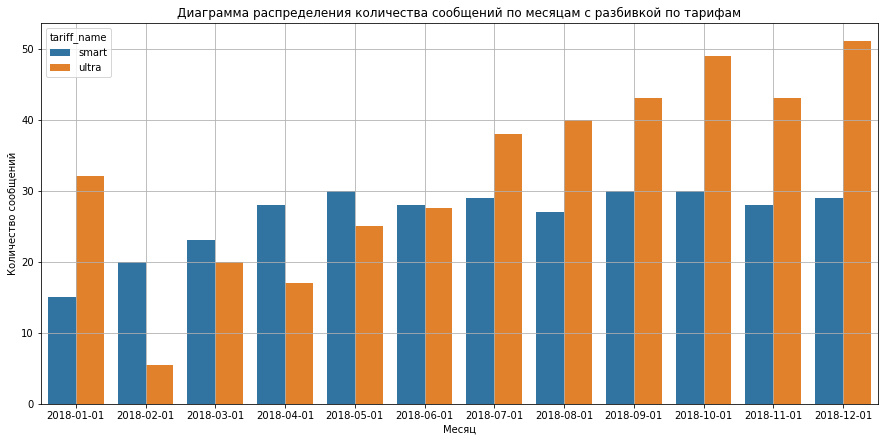

In [64]:
plt.figure(figsize=(15, 7))
sns.barplot(x='month', y='median', data=us_sms, hue='tariff_name')
plt.title('Диаграмма распределения количества сообщений по месяцам с разбивкой по тарифам')
plt.xlabel('Месяц')
plt.ylabel('Количество сообщений')
plt.grid()
plt.show()

На графике видно, что пользователи с тарифом ultra используют больше сообщений в среднем в месяц. Это логично, так как у них в пакет услуг включено 1000 бесплатных сообщений. Но при этом, самый высокий средний показатель - 62 сообщения, это всего лишь на 12 сообщений больше пакета smart.

Теперь рассмотрим распределение по звонкам:

In [65]:
us_call = final_at.pivot_table(index=['month', 'tariff_name'], 
                               values='duration', 
                               aggfunc=('count', 'mean', 'sum', 'median')).reset_index()
us_call.head()

,month,tariff_name,count,mean,median,sum
0,2018-01-01,smart,34,203.852941,162.5,6931.0
1,2018-01-01,ultra,9,428.111111,382.0,3853.0
2,2018-02-01,smart,58,298.689655,258.0,17324.0
3,2018-02-01,ultra,24,297.125000,168.0,7131.0
4,2018-03-01,smart,77,390.051948,409.0,30034.0


Визуализируем для наглядности:

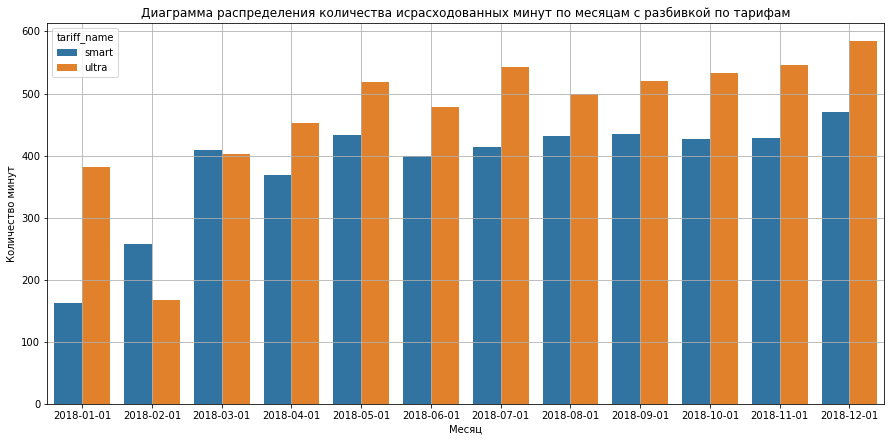

In [66]:
plt.figure(figsize=(15, 7))
sns.barplot(x='month', y='median', data=us_call, hue='tariff_name')
plt.title('Диаграмма распределения количества исрасходованных минут по месяцам с разбивкой по тарифам')
plt.xlabel('Месяц')
plt.ylabel('Количество минут')
plt.grid()
plt.show()

Пользователи тарифа ultra в среднем не превышают 600 минут в месяц. Для бизнеса это выгоднее, так как пользователи не используют полностью включенный пакет.

Рассмотрим теперь на распределение интернет-трафика по тарифам:

In [67]:
us_gb = final_at.pivot_table(index=['month', 'tariff_name'], 
                             values='gb_used', 
                             aggfunc=('count', 'mean', 'sum', 'median')).reset_index()
us_gb.head()

,month,tariff_name,count,mean,median,sum
0,2018-01-01,smart,34,8.735294,7.0,297.0
1,2018-01-01,ultra,9,13.222222,15.0,119.0
2,2018-02-01,smart,58,11.844828,13.0,687.0
3,2018-02-01,ultra,24,12.000000,7.5,288.0
4,2018-03-01,smart,77,15.233766,16.0,1173.0


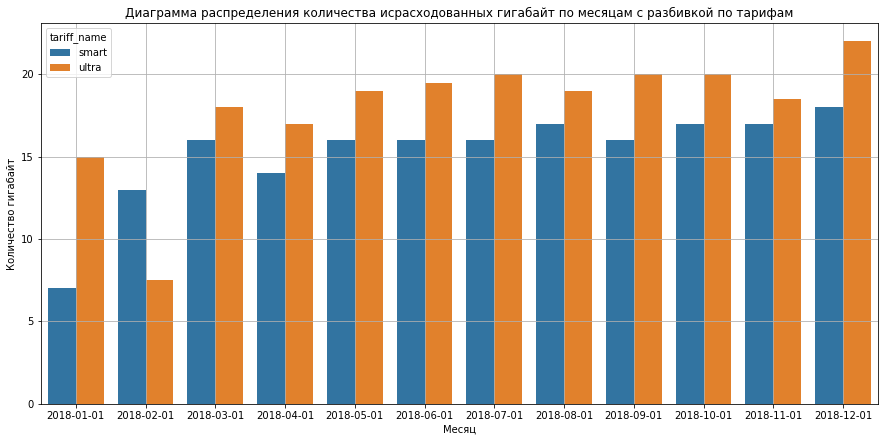

In [68]:
plt.figure(figsize=(15, 7))
sns.barplot(x='month', y='median', data=us_gb, hue='tariff_name')
plt.title('Диаграмма распределения количества исрасходованных гигабайт по месяцам с разбивкой по тарифам')
plt.xlabel('Месяц')
plt.ylabel('Количество гигабайт')
plt.grid()
plt.show()

По интернету пользователи тарифа ultra довольно объемно используют интернет-трафик. Возможно по этой причине они и выбирают данный тариф. Хотя я бы не сказала, что разница между тарифами слишком существенна. Например, в феврале пользователи тарифа смарт больше в среднем расходовали интернет. В ноябре также разница расходов трафика между пользователями разных тарифов минимальна.


Проанализировав выше 3 показатели, наблюдается одна закономерность: в феврале пользователи тарифа Смарт активнее пользовались доступными продуктами своего тарифа.

### Рассчет дисперсии, стандартного отклонения.

Для звонков, смс и интернет-трафика посчитаем дисперсию и стандартное отклонение.

In [69]:
variance_duration = final_at.groupby('tariff_name')['duration'].agg(['var', 'std'])
variance_duration.style.format("{:.1f}")

,var,std
tariff_name,,
smart,36219.3,190.3
ultra,100873.6,317.6


In [70]:
variance_sms = final_at.groupby('tariff_name')['sms'].agg(['var', 'std'])
variance_sms.style.format("{:.1f}")

,var,std
tariff_name,,
smart,796.8,28.2
ultra,2285.3,47.8


In [71]:
variance_gb = final_at.groupby('tariff_name')['gb_used'].agg(['var', 'std'])
variance_gb.style.format("{:.1f}")

,var,std
tariff_name,,
smart,33.0,5.7
ultra,97.1,9.9


### Построение гистограмм по основным показателям

Для удобства выведем отдельные таблицы для каждого тарифа.

In [72]:
final_at_smart = final_at.query('tariff_name == "smart"').reset_index()
final_at_ultra = final_at.query('tariff_name == "ultra"').reset_index()

#### Гистограмма сообщений

Теперь построим графики для каждого тарифа по основным показателям.

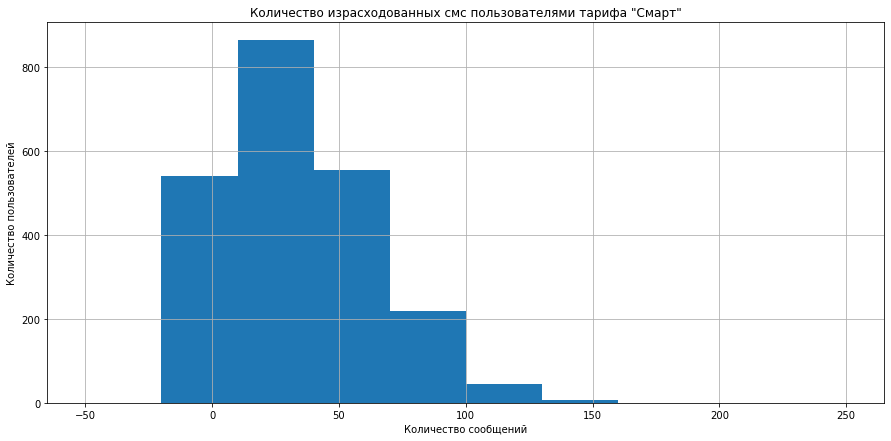

In [73]:
plt.figure(figsize=(15, 7))
final_at_smart['sms'].hist(bins=10, range=(-50, 250))
plt.title('Количество израсходованных смс пользователями тарифа "Смарт"')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество пользователей')
plt.show()

Начнем с сообщений для тарифа smart. Здесь видно, что показатели в среднем варьируются в диапазоне от 12 до 35. Также помним про лимит сообщений по данному тарифу, он составляет 50 смс. 

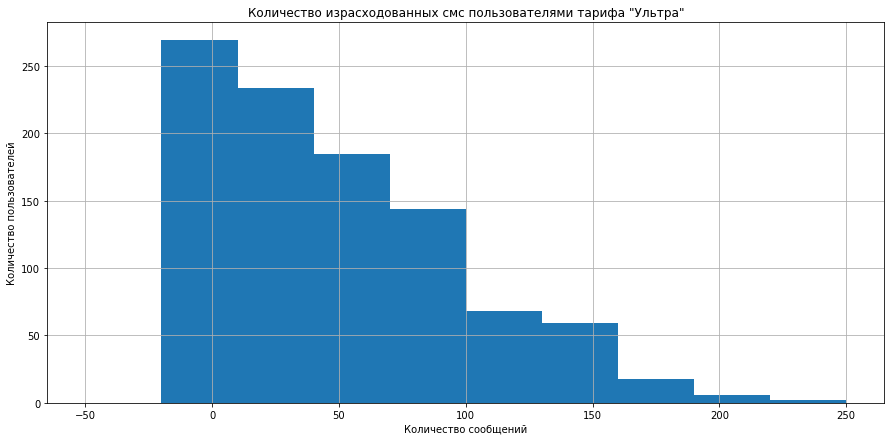

In [74]:
plt.figure(figsize=(15, 7))
final_at_ultra['sms'].hist(bins=10, range=(-50, 250))
plt.title('Количество израсходованных смс пользователями тарифа "Ультра"')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество пользователей')
plt.show()

Если рассматривать тариф ultra, то на графике видно, что пользователи в основном используют до 100 сообщений, а среднем около 60, но также есть исключения. Полный пакет, который включает в себя 1000 сообщений, полностью не используется.

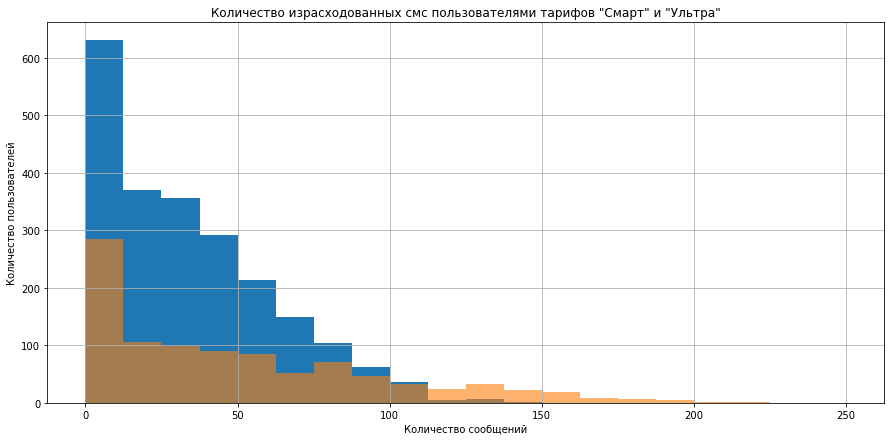

In [75]:
plt.figure(figsize=(15, 7))
final_at_smart['sms'].hist(bins=20, range=(0, 250))
final_at_ultra['sms'].hist(bins=20, range=(0, 250), alpha=0.6)
plt.title('Количество израсходованных смс пользователями тарифов "Смарт" и "Ультра"')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество пользователей')
plt.show()

Для наглядности посмотрим гистограмму сразу для двух тарифов. На самом деле, если учесть, что пользователей разное количество, то можно увидеть, что они не сильно отличаются, большинству клиентов достаточно до 60-70 сообщений в месяц. Также, все три графика отображает частоту значений в скошенном вправо наборе данных.

#### Гистограмма звонков

Теперь построим гистограммы и посмотрим испозованные минуты.

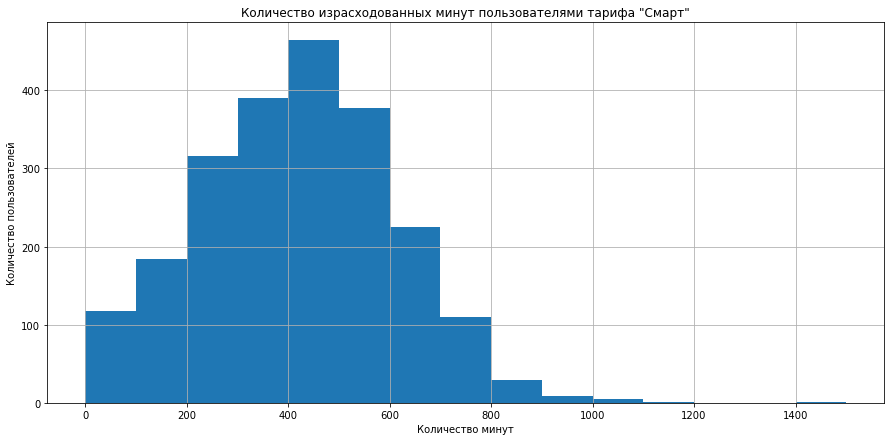

In [76]:
plt.figure(figsize=(15, 7))
final_at_smart['duration'].hist(bins=15, range=(0, 1500))
plt.title('Количество израсходованных минут пользователями тарифа "Смарт"')
plt.xlabel('Количество минут')
plt.ylabel('Количество пользователей')
plt.show()

Гистограмма звонков для тарифа smart. В среднем пользователи используют от 300 до 600 минут, также есть исключения, но количество таких пользователей небольшое. Большинство пользователей укладываются в свой лимит разговоров, который составляет 500 минут в месяц.

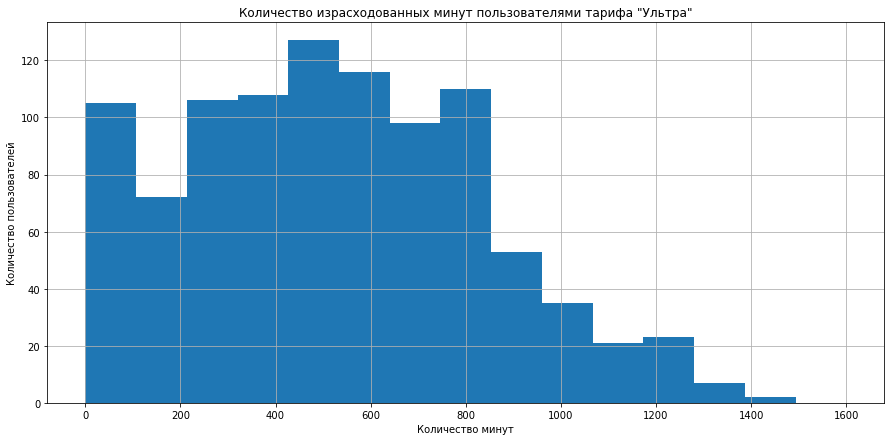

In [77]:
plt.figure(figsize=(15, 7))
final_at_ultra['duration'].hist(bins=15, range=(0, 1600))
plt.title('Количество израсходованных минут пользователями тарифа "Ультра"')
plt.xlabel('Количество минут')
plt.ylabel('Количество пользователей')
plt.show()

Здесь уже другая картина. Если смотреть на сводную таблицу выше, то там в среднем пользователи тарифа ultra используют до 800 минут разговора при доступных 3000. Крайне малое количество пользователей превышает 800 минут. Опять же предположу, что для бизнеса это выгоднее, так как клиент покупает более дорогой тариф, но использует включенные минуты разговоров практически в рамках тарифа smart.

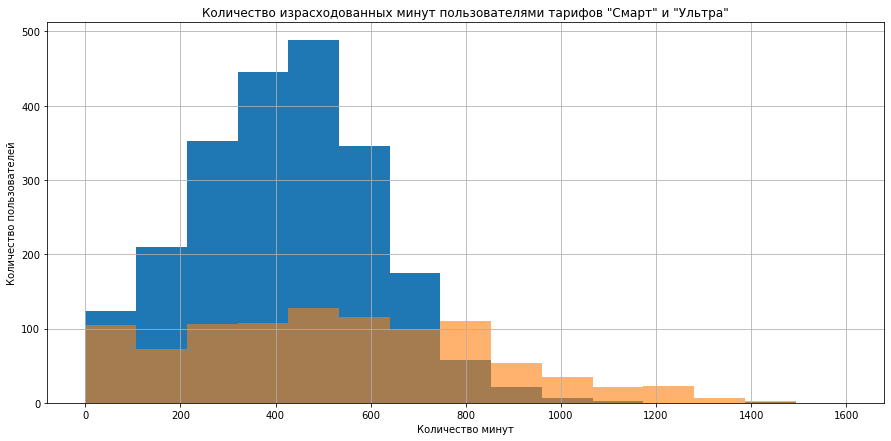

In [78]:
plt.figure(figsize=(15, 7))
final_at_smart['duration'].hist(bins=15, range=(0, 1600))
final_at_ultra['duration'].hist(bins=15, range=(0, 1600), alpha=0.6)
plt.title('Количество израсходованных минут пользователями тарифов "Смарт" и "Ультра"')
plt.xlabel('Количество минут')
plt.ylabel('Количество пользователей')
plt.show()

Как раз на графике видно, что пользователи двух тарифов чаще всего используют примерно одинаковое количество минут разговоров.Если рассматривать тариф "Смарт", то распределение данных харектиризуется как нормальное. По тарифу "Ультра" гистограмма скорее равномерного распределения, хотя имеет тенденцию скоса вправо.

#### Гистограмма интернет-трафика

Осталось построить графики для интернет-трафика по каждому тарифу.

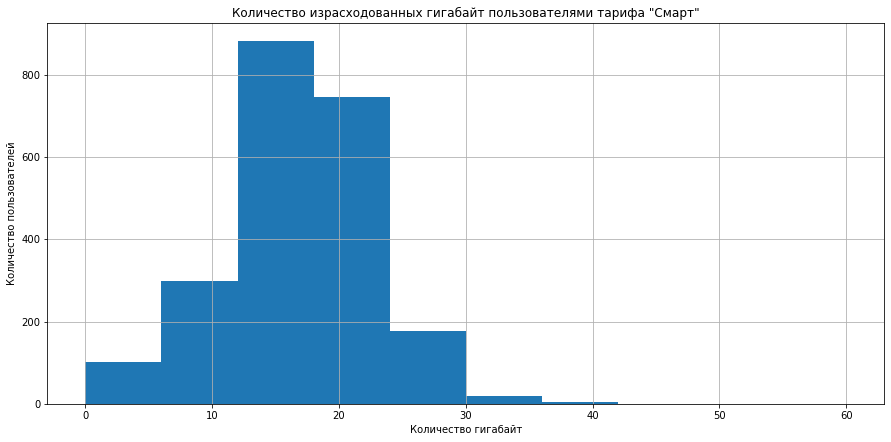

In [79]:
plt.figure(figsize=(15, 7))
final_at_smart['gb_used'].hist(bins=10, range=(0, 60))
plt.title('Количество израсходованных гигабайт пользователями тарифа "Смарт"')
plt.xlabel('Количество гигабайт')
plt.ylabel('Количество пользователей')
plt.show()

Исходя из полученного графика видно, что пользователи тарифа smart зачастую превышают тарифный план в размере 15 гб, в среднем диапазон в пределах 1-20 гб. Из этого следуют, что за интернет клиенты доплачивают сверх пакета.

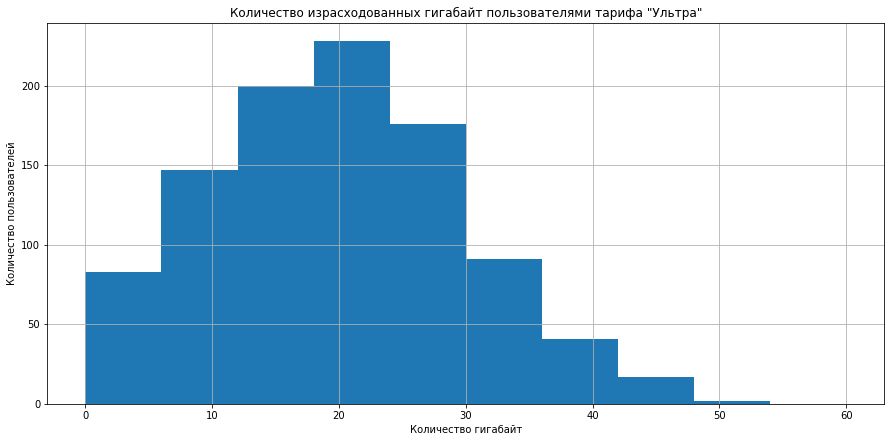

In [80]:
plt.figure(figsize=(15, 7))
final_at_ultra['gb_used'].hist(bins=10, range=(0, 60))
plt.title('Количество израсходованных гигабайт пользователями тарифа "Ультра"')
plt.xlabel('Количество гигабайт')
plt.ylabel('Количество пользователей')
plt.show()

Пользователи тарифа ultra в основном используют интернет-трафик в диапазоне  с 10-30 гб, при лимите пакета в 30 гб, превышение лимита у незначительного числа пользователей. Также можно сказать, что пользователи активно пользуются интернетом. 

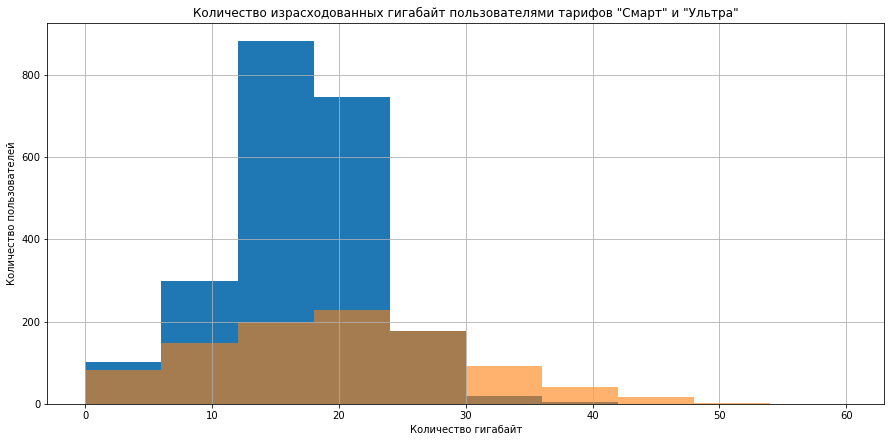

In [81]:
plt.figure(figsize=(15, 7))
final_at_smart['gb_used'].hist(bins=10, range=(0, 60))
final_at_ultra['gb_used'].hist(bins=10, range=(0, 60), alpha=0.6)
plt.title('Количество израсходованных гигабайт пользователями тарифов "Смарт" и "Ультра"')
plt.xlabel('Количество гигабайт')
plt.ylabel('Количество пользователей')
plt.show()

На общей гистограмме видно, что пользователи тарифа ultra активнее пользуются интернетом. 

## Проверка гипотез

### Гипотеза № 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны. 

Альтернативная гипотеза (Н1): Средняя выручка пользователей тарифов «Ультра» и средняя выручка тарифа "Смарт" не равны.

Для удобства выведем выручки по тарифам в отдельные списки:

In [82]:
revenue_smart = final_at_smart['revenue'].to_list()

In [83]:
revenue_ultra = final_at_ultra['revenue'].to_list()

In [84]:
alpha = 0.05

results = st.ttest_ind(
    revenue_smart,
    revenue_ultra,
    equal_var=False
)

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.2606313931076085e-250
Отвергаем нулевую гипотезу


Если нулевая гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» равны отвергается, тогда соответственно есть основания полагать, что средние выручки пользователей тарифов «Ультра» и тарифа "Смарт" отличаются.

### Гипотеза № 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Также формулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 

Альтернативная гипотеза (Н1): Средняя выручка пользователей из Москвы и выручка пользователей из других регионов не равны.



Выводим выручку Москвы и других регионов в отдельные списки

In [85]:
revenue_msk = final_at.query('city == "Москва"').reset_index()
revenue_msk = revenue_msk['revenue'].to_list()

In [86]:
revenue_other = final_at.query('city != "Москва"').reset_index()
revenue_other = revenue_other['revenue'].to_list()

In [87]:
alpha = 0.05

results = st.ttest_ind(
    revenue_msk,
    revenue_other,
    equal_var=False
)

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Исходя из результатов проведенного теста, у нас отсутствуют основания делать вывод о значимом различии средних выручек между пользователями из Москвы и пользователями других регионов.

## Дополнительный анализ выручки

Дополнительно рассмотрим выручку 2-х тарифов:

In [88]:
revenue = final_at.copy()

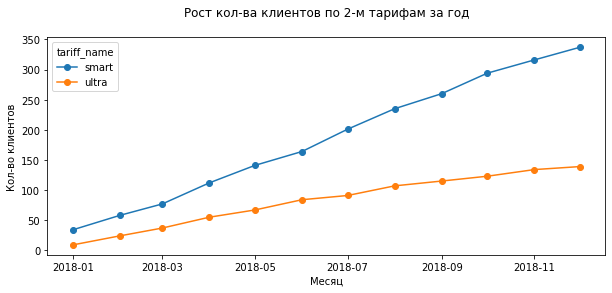

In [89]:
(revenue
 .pivot_table(index='tariff_name', columns='month', values='user_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Рост кол-ва клиентов по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Кол-во клиентов')
plt.show()

До марта рост двух тарифов был одинаковым, далее рост клиентов тарифа смарт увеличился.


Рассмотрим ежемесячную выручку от одного обонента по месяцам:

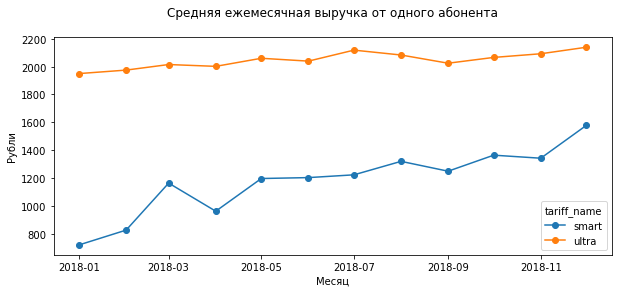

In [90]:
(revenue
 .pivot_table(index='tariff_name', columns='month', values='revenue', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средняя ежемесячная выручка от одного абонента'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли')
plt.show()

При том, что выручка от абонента тарифа Ультра выше, видна тенденция роста средней выручки от абонента в тарифе Смарт.

Теперь рассмотрим суммарную ежемесячную выручку по двум тарифам:

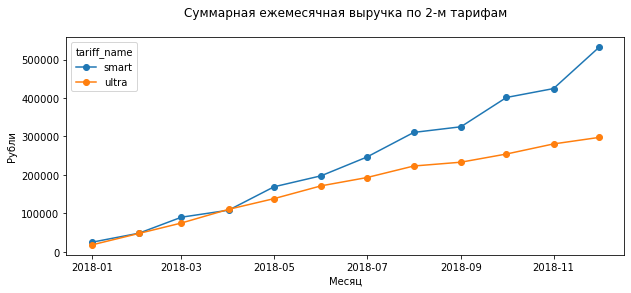

In [91]:
(revenue
 .pivot_table(index='tariff_name', columns='month', values='revenue', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Суммарная ежемесячная выручка по 2-м тарифам'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли')
plt.show()

Как раз на данном графике видна тенденция роста выручки тарифов Смарт.

Также выведем отдельные цифры для размышления по оттоку клиентов:

In [92]:
print ('Количество клиентов, покинувших компанию за год, составляет: ', user['churn_date'].notna().sum())
print('......................................................................................')
print ('Количество клиентов, покинувших компанию за последние 4 месяца 2018 года на двух тарифах, составляет: ',
       user.query('churn_date > "2018-09-25"')['churn_date'].notna().sum()
      )
print('......................................................................................')
print ('%  от общего количества всех клиентов, покинувших компанию за последние 4 месяца 2018 года на двух тарифах, составляет: ',
    (user.query('churn_date > "2018-09-25"')['churn_date'].notna().sum()/user['churn_date'].notna().sum()*100).round(1)
)
print('......................................................................................')
print ('Распределение оттока клиентов на тарифах за последние 4 месяца 2018 года')
user.query('churn_date > "2018-09-25"').groupby('tariff')['churn_date'].count().to_frame()

Количество клиентов, покинувших компанию за год, составляет:  38
......................................................................................
Количество клиентов, покинувших компанию за последние 4 месяца 2018 года на двух тарифах, составляет:  35
......................................................................................
%  от общего количества всех клиентов, покинувших компанию за последние 4 месяца 2018 года на двух тарифах, составляет:  92.1
......................................................................................
Распределение оттока клиентов на тарифах за последние 4 месяца 2018 года


,churn_date
tariff,
smart,22
ultra,13


Полученные нами цифры говорят, что отток усиливается, при чем в тарифе Смарт он выше. Могу предположить, что это связано с тем, что разница в стоимости пакета услуг тарифов Смарт и Ультра огромная. Пользователям не нужен полный пакет Ультра, но так де им не хватает пакета Смарт. В этом случае, может увеличиваться отток клиентов. Для уменьшения оттока клиентов, бизнесу необходимо разработать другие тарифы, которые будут комфортны для пользователей.

## Общий вывод

Для исследования тарифов мы получили несколько датасетов с данными о пользователях. У нас были сведения о количестве используемых клиентами сообщений, звонков и интернет-трафика за 2018 год. Перед началом исследования мы проделали следующую работу:
1. Так как сведения с датами были сохранены в формате object, мы поменяли формат.
2. Так как компания производит рассчет в минутах, а интернет-трафик в гигабайтах, мы округлили данные с минутами разговоров в большую сторону, мегабайты перевели в гигабайты и также округлили в большую сторону для дальнейших рассчетов.
3. В каждую таблицу добавили столбец, где даты округлили до месяцев для удобства, так как нас интересует расход пользователей в месяц.

После этого, мы создали три новые таблицы, где сгруппировали данные по месяцам и пользователям и таким образом у нас появились данные, сколько пользователь тратит смс, звонков и интернет-трафика в месяц в течение года.

Далее, мы объеденили полученные таблицы между собой с данными о пользователях и сведениями о тарифах. Удалили ненужные столбцы и у нас получилась полноценная аналитическая таблица для дальнейшего исследования.

В дальнейщем, мы создали функцию, которая рассчитала выручку с каждого пользователя с учетом перерасхода по тарифам.

	           
tariff_name	   count	mean	    sum	

smart	       2229.0	1290.0	   2875351.0

ultra	       985.0	2070.2	   2039100.0


Обратите внимание, что пользователей с тарифом smart в 2,3 раза превышает пользователей тарифа ultra, при этом выручка выше всего в 1,4 раза. Также видно, что пользователи тарифа smart в среднем часто превышают пакет включенных услуг (стоимость пакета - 550 рублей, средняя выручка - 1290). Стоимость услуг тарифа ultra составляет 1950 рублей, из рассчетов средняя - 2070 рублей. Это говорит о том, что пользователям в среднем хватает включенных в пакет минут, смс и интернет трафика.

После этого мы рассчитали дисперсии и стандартные отклонения по основным показателям для каждого тарифа:

Для звонков:

tariff_name	       var	     std

smart	         36219.3	190.3

ultra	        100873.6	317.6


Для смс-сообщений:

tariff_name	     var	       std
		
smart	         796.8	      28.2

ultra	         2285.3	      47.8


Для интернет-трафика:


tariff_name	    var	    std
	
smart	        33.0	5.7

ultra	        97.1	9.9


Также, мы проанализировали расход сообщений, звонков и интернет-трафика по месяцам каждого пользователя по каждому тарифу по отдельности. Постороили гистограммы для сравнения. Краткие выводы по ним:
1. Сообщения для тарифа smart. Показатели в среднем варьируются в диапазоне от 12 до 35 смс в месяц. Также помним про лимит сообщений по данному тарифу, он составляет 50 смс. Если рассматривать тариф ultra, пользователи в основном используют до 100 сообщений, а среднем около 60, но также есть исключения, полный пакет, который включает в себя 1000 сообщений не используют. Если учесть, что пользователей разное количество, то можно увидеть, что они не сильно отличаются, большинству клиентов достаточно до 60-70 сообщений в месяц.
2. Звонки для тарифа smart: в среднем пользователи используют от 300 до 600 минут, также есть исключения, но количество таких пользователей небольшое. Большинство пользователей укладываются в свой лимит разговоров, который составляет 500 минут в месяц. Звонки для тарифа ultra: Если вспомнить сводную таблицу выше, то там в среднем пользователи тарифа ultra используют до 800 минут разговора при доступных 3000. Крайне малое количество пользователей превышает 800 минут. Опять же предположу, что для бизнеса это выгоднее, так как клиент покупает более дорогой тариф, но использует включенные минуты разговоров практически в рамках тарифа smart. Пользователи двух тарифов чаще всего используют примерно одинаковое количество минут разговоров.
3. Пользователи тарифа smart зачастую превышают тарифный план в размере 15 гб, в среднем диапазон в пределах 1-20 гб. Из этого следуют, что за интернет клиенты доплачивают сверх пакета. Пользователи тарифа ultra в основном используют интернет-трафик в диапазоне  с 10-30 гб, при лимите пакета в 30 гб, превышение лимита у незначительного числа пользователей. Также можно сказать, что пользователи активно пользуются интернетом. 

В конце мы проверили 2 гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

После проведенного теста по 1-й гипотезе, есть основания полагать, что средние выручки пользователей тарифов «Ультра» и тарифа "Смарт" отличаются. 

Исходя из результатов проведенного теста по 2-й гипотезе, у нас отсутствуют основания делать вывод о значимом различии средних выручек между пользователями из Москвы и пользователями других регионов.

Если рассматривать рекомендации бизнесу по выбору рекламы для тарифов, на мой взгляд выгоднее тариф «Ультра». Пользователи зачастую не используют имеющиеся звонки и смс, находятся в диапазоне тарифа "Смарт", но при этом стоимость тарифа почти в 4 раза выше. Также, я обратила внимание, что пользователи тарифа "Смарт" часто перерасходуют интернет-трафик, поэтому эту метрику можно взять за основу для привлечения их к покупке тарифа "Ультра", так как интернета в нем в два раза больше. Для уменьшения оттока клиентов, бизнесу необходимо разработать другие тарифы, которые будут комфортны для пользователей.

 